In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import uniform
%matplotlib inline

In [2]:
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from mlxtend.preprocessing import minmax_scaling

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def show_uniq(col):
    print('Train: {}'.format(train[col].unique()))
    print('Test: {}'.format(test[col].unique()))

In [5]:
def show_uniqs(cols):
    for col in cols:
        print(col)
        show_uniq(col)
        print('=======================================')

# 1. Downloading and exploring data

## 1.1 Train

In [6]:
train = pd.read_csv(r'data\train.csv')

In [7]:
cat_original_columns = train.select_dtypes(exclude=np.number).columns
num_original_columns = train.select_dtypes(include=np.number).columns.drop('Id')

In [8]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [9]:
train.shape

(1460, 81)

In [10]:
# columns with gaps
empty_columns_train = train.columns[[ind for ind,x in enumerate(train.isnull().any()) if x]]

In [11]:
count_empty_columns_train = train[empty_columns_train].isnull().sum(axis = 0)
count_empty_columns_train

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'LotFrontage'),
  Text(1, 0, 'Alley'),
  Text(2, 0, 'MasVnrType'),
  Text(3, 0, 'MasVnrArea'),
  Text(4, 0, 'BsmtQual'),
  Text(5, 0, 'BsmtCond'),
  Text(6, 0, 'BsmtExposure'),
  Text(7, 0, 'BsmtFinType1'),
  Text(8, 0, 'BsmtFinType2'),
  Text(9, 0, 'Electrical'),
  Text(10, 0, 'FireplaceQu'),
  Text(11, 0, 'GarageType'),
  Text(12, 0, 'GarageYrBlt'),
  Text(13, 0, 'GarageFinish'),
  Text(14, 0, 'GarageQual'),
  Text(15, 0, 'GarageCond'),
  Text(16, 0, 'PoolQC'),
  Text(17, 0, 'Fence'),
  Text(18, 0, 'MiscFeature')])

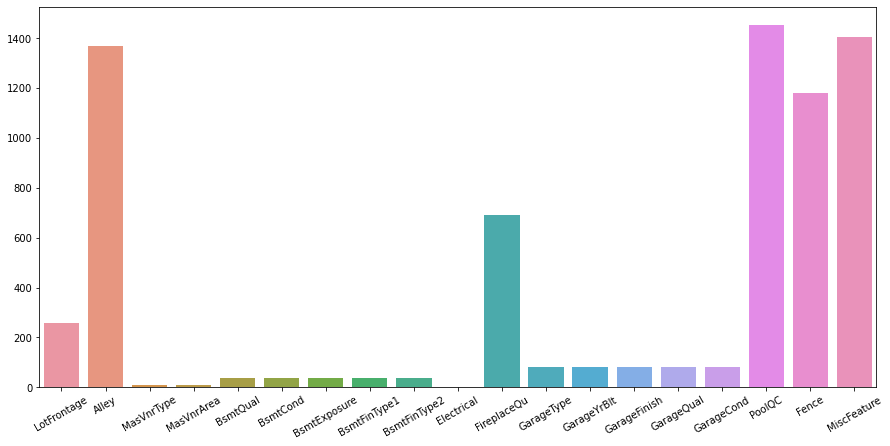

In [12]:
plt.figure(figsize=(15,7))
ploting = sns.barplot(x = count_empty_columns_train.index,y = count_empty_columns_train.values)
plt.xticks(rotation=30)

A lot of feature have missing values. Let's look at those that have more than 40% passes.

In [13]:
(train.shape[0]/100)*40

584.0

In [14]:
for c, name_col in zip(count_empty_columns_train,count_empty_columns_train.index):
    if c > 584:
        print(name_col)

Alley
FireplaceQu
PoolQC
Fence
MiscFeature


+ Alley - Missing values mean the absence of an alley
+ FireplaceQu - Missing values mean the absence of a fireplace
+ PoolQC - Missing values mean the absence of a pool
+ Fence - Missing values mean the absence of a fence
+ MiscFeature - Missing values mean the absence of a other feature.

## 1.2 Test

In [15]:
test = pd.read_csv(r'data\test.csv')

In [16]:
test['Id']

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [17]:
test.shape

(1459, 80)

In [18]:
# columns with gaps
empty_columns_test = test.columns[[ind for ind,x in enumerate(test.isnull().any()) if x]]

In [19]:
count_empty_columns_test = test[empty_columns_test].isnull().sum(axis = 0)
count_empty_columns_test

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'MSZoning'),
  Text(1, 0, 'LotFrontage'),
  Text(2, 0, 'Alley'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Exterior1st'),
  Text(5, 0, 'Exterior2nd'),
  Text(6, 0, 'MasVnrType'),
  Text(7, 0, 'MasVnrArea'),
  Text(8, 0, 'BsmtQual'),
  Text(9, 0, 'BsmtCond'),
  Text(10, 0, 'BsmtExposure'),
  Text(11, 0, 'BsmtFinType1'),
  Text(12, 0, 'BsmtFinSF1'),
  Text(13, 0, 'BsmtFinType2'),
  Text(14, 0, 'BsmtFinSF2'),
  Text(15, 0, 'BsmtUnfSF'),
  Text(16, 0, 'TotalBsmtSF'),
  Text(17, 0, 'BsmtFullBath'),
  Text(18, 0, 'BsmtHalfBath'),
  Text(19, 0, 'KitchenQual'),
  Text(20, 0, 'Functional'),
  Text(21, 0, 'FireplaceQu'),
  Text(22, 0, 'GarageType'),
  Text(23, 0, 'GarageYrBlt'),
  Text(24, 0, 'GarageFinish'),
  Text(25, 0, 'GarageCars'),
  Text(26, 0, 'GarageArea'),
  Text(27, 0, 'GarageQual'),
  Text(28, 0, 'GarageCond'),
  Text(29, 0,

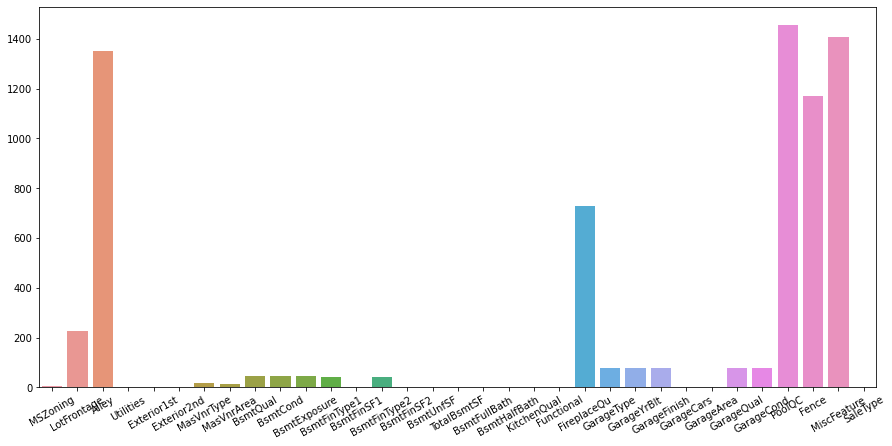

In [20]:
plt.figure(figsize=(15,7))
ploting = sns.barplot(x = count_empty_columns_test.index,y = count_empty_columns_test.values)
plt.xticks(rotation=30)

Let's look at the columns in which there are missing values on the test, but not on train

In [21]:
for col in count_empty_columns_test.index:
    if col not in count_empty_columns_train:
        print(col)

MSZoning
Utilities
Exterior1st
Exterior2nd
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
KitchenQual
Functional
GarageCars
GarageArea
SaleType


This will be important when transforming data

# 2. Processing of missing values in groups

## 2.1 Garage

In [22]:
garage_colums = []
regexp = re.compile(r"([-a-zA-Z]+)?"+r"Garage"+r"([-a-zA-Z]+)?")
for col in train.columns:
    if regexp.search(col):
        garage_colums.append(col)
garage_colums = np.array(garage_colums)
garage_colums

array(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond'], dtype='<U12')

In [23]:
train[garage_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageType    1379 non-null   object 
 1   GarageYrBlt   1379 non-null   float64
 2   GarageFinish  1379 non-null   object 
 3   GarageCars    1460 non-null   int64  
 4   GarageArea    1460 non-null   int64  
 5   GarageQual    1379 non-null   object 
 6   GarageCond    1379 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 80.0+ KB


In [24]:
test[garage_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageType    1383 non-null   object 
 1   GarageYrBlt   1381 non-null   float64
 2   GarageFinish  1381 non-null   object 
 3   GarageCars    1458 non-null   float64
 4   GarageArea    1458 non-null   float64
 5   GarageQual    1381 non-null   object 
 6   GarageCond    1381 non-null   object 
dtypes: float64(3), object(4)
memory usage: 79.9+ KB


In [25]:
garage_num_cols = train[garage_colums].select_dtypes(include=np.number).columns
garage_cat_cols = train[garage_colums].select_dtypes(exclude=np.number).columns

Working with numerical missing data. Use it even for data because i'm gonna use random forest

In [26]:
for col in garage_num_cols:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

Working with categorical missing data

In [27]:
# Shows if there is another notation for nan in the data
show_uniqs(garage_cat_cols)

GarageType
Train: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
Test: ['Attchd' 'Detchd' 'BuiltIn' nan 'Basment' '2Types' 'CarPort']
GarageFinish
Train: ['RFn' 'Unf' 'Fin' nan]
Test: ['Unf' 'Fin' 'RFn' nan]
GarageQual
Train: ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
Test: ['TA' nan 'Fa' 'Gd' 'Po']
GarageCond
Train: ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
Test: ['TA' nan 'Fa' 'Gd' 'Po' 'Ex']


In [28]:
for col in garage_cat_cols:
    train[col] = train[col].fillna('NA')
    test[col] = test[col].fillna('NA')
    # show column if classes in test column not in train 
    if not set(test[col].unique()).issubset(train[col].unique()):
        print(col)

In [29]:
train[garage_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageType    1460 non-null   object 
 1   GarageYrBlt   1460 non-null   float64
 2   GarageFinish  1460 non-null   object 
 3   GarageCars    1460 non-null   int64  
 4   GarageArea    1460 non-null   int64  
 5   GarageQual    1460 non-null   object 
 6   GarageCond    1460 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 80.0+ KB


In [30]:
test[garage_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageType    1459 non-null   object 
 1   GarageYrBlt   1459 non-null   float64
 2   GarageFinish  1459 non-null   object 
 3   GarageCars    1459 non-null   float64
 4   GarageArea    1459 non-null   float64
 5   GarageQual    1459 non-null   object 
 6   GarageCond    1459 non-null   object 
dtypes: float64(3), object(4)
memory usage: 79.9+ KB


## 2.2 Basement

In [31]:
basement_colums = []
regexp = re.compile(r"([-a-zA-Z]+)?"+r"Bsmt"+r"([-a-zA-Z]+)?")
for col in train.columns:
    if regexp.search(col):
        basement_colums.append(col)
basement_colums = np.array(basement_colums)
basement_colums

array(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'], dtype='<U12')

In [32]:
train[basement_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtQual      1423 non-null   object
 1   BsmtCond      1423 non-null   object
 2   BsmtExposure  1422 non-null   object
 3   BsmtFinType1  1423 non-null   object
 4   BsmtFinSF1    1460 non-null   int64 
 5   BsmtFinType2  1422 non-null   object
 6   BsmtFinSF2    1460 non-null   int64 
 7   BsmtUnfSF     1460 non-null   int64 
 8   TotalBsmtSF   1460 non-null   int64 
 9   BsmtFullBath  1460 non-null   int64 
 10  BsmtHalfBath  1460 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 125.6+ KB


In [33]:
test[basement_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BsmtQual      1415 non-null   object 
 1   BsmtCond      1414 non-null   object 
 2   BsmtExposure  1415 non-null   object 
 3   BsmtFinType1  1417 non-null   object 
 4   BsmtFinSF1    1458 non-null   float64
 5   BsmtFinType2  1417 non-null   object 
 6   BsmtFinSF2    1458 non-null   float64
 7   BsmtUnfSF     1458 non-null   float64
 8   TotalBsmtSF   1458 non-null   float64
 9   BsmtFullBath  1457 non-null   float64
 10  BsmtHalfBath  1457 non-null   float64
dtypes: float64(6), object(5)
memory usage: 125.5+ KB


In [34]:
basement_num_cols = train[basement_colums].select_dtypes(include=np.number).columns
basement_cat_cols = train[basement_colums].select_dtypes(exclude=np.number).columns

Working with numerical missing data

In [35]:
for col in basement_num_cols:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

Working with categorical missing data

In [36]:
show_uniqs(basement_cat_cols)

BsmtQual
Train: ['Gd' 'TA' 'Ex' nan 'Fa']
Test: ['TA' 'Gd' 'Ex' 'Fa' nan]
BsmtCond
Train: ['TA' 'Gd' nan 'Fa' 'Po']
Test: ['TA' 'Po' 'Fa' 'Gd' nan]
BsmtExposure
Train: ['No' 'Gd' 'Mn' 'Av' nan]
Test: ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType1
Train: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
Test: ['Rec' 'ALQ' 'GLQ' 'Unf' 'BLQ' 'LwQ' nan]
BsmtFinType2
Train: ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Test: ['LwQ' 'Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' nan]


In [37]:
# show column if classes in test column not in train 
for col in basement_cat_cols:
    train[col] = train[col].fillna('NA')
    test[col] = test[col].fillna('NA')
    if not set(test[col].unique()).issubset(train[col].unique()):
        print(col)

In [38]:
train[basement_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtQual      1460 non-null   object
 1   BsmtCond      1460 non-null   object
 2   BsmtExposure  1460 non-null   object
 3   BsmtFinType1  1460 non-null   object
 4   BsmtFinSF1    1460 non-null   int64 
 5   BsmtFinType2  1460 non-null   object
 6   BsmtFinSF2    1460 non-null   int64 
 7   BsmtUnfSF     1460 non-null   int64 
 8   TotalBsmtSF   1460 non-null   int64 
 9   BsmtFullBath  1460 non-null   int64 
 10  BsmtHalfBath  1460 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 125.6+ KB


In [39]:
test[basement_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BsmtQual      1459 non-null   object 
 1   BsmtCond      1459 non-null   object 
 2   BsmtExposure  1459 non-null   object 
 3   BsmtFinType1  1459 non-null   object 
 4   BsmtFinSF1    1459 non-null   float64
 5   BsmtFinType2  1459 non-null   object 
 6   BsmtFinSF2    1459 non-null   float64
 7   BsmtUnfSF     1459 non-null   float64
 8   TotalBsmtSF   1459 non-null   float64
 9   BsmtFullBath  1459 non-null   float64
 10  BsmtHalfBath  1459 non-null   float64
dtypes: float64(6), object(5)
memory usage: 125.5+ KB


## 2.3 Masonry veneer 

In [40]:
masvnr_colums = []
regexp = re.compile(r"([-a-zA-Z]+)?"+r"MasVnr"+r"([-a-zA-Z]+)?")
for col in train.columns:
    if regexp.search(col):
        masvnr_colums.append(col)
masvnr_colums = np.array(masvnr_colums)
masvnr_colums

array(['MasVnrType', 'MasVnrArea'], dtype='<U10')

In [41]:
train[masvnr_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MasVnrType  1452 non-null   object 
 1   MasVnrArea  1452 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.9+ KB


In [42]:
test[masvnr_colums].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MasVnrType  1443 non-null   object 
 1   MasVnrArea  1444 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.9+ KB


In [43]:
masvnr_num_cols = train[masvnr_colums].select_dtypes(include=np.number).columns
masvnr_cat_cols = train[masvnr_colums].select_dtypes(exclude=np.number).columns

In [44]:
# if we have a missing value in MasVnrArea column than we have missing value in MasVnrType column on a same row
all(train.loc[train['MasVnrArea'].isnull()].index == train.loc[train['MasVnrType'].isnull()].index)

True

In [45]:
train.loc[train['MasVnrArea'] == 0][masvnr_colums].head()

,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


Working with numerical missing data

In [46]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

Working with categorical missing data

In [47]:
show_uniqs(masvnr_cat_cols)

MasVnrType
Train: ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
Test: ['None' 'BrkFace' 'Stone' 'BrkCmn' nan]


In [48]:
train['MasVnrType'] = train['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

In [49]:
show_uniqs(masvnr_cat_cols)

MasVnrType
Train: ['BrkFace' 'None' 'Stone' 'BrkCmn']
Test: ['None' 'BrkFace' 'Stone' 'BrkCmn']


## 2.4 Pool

In [50]:
pool_colums = []
regexp = re.compile(r"([-a-zA-Z]+)?"+r"Pool"+r"([-a-zA-Z]+)?")
for col in train.columns:
    if regexp.search(col):
        pool_colums.append(col)
pool_colums = np.array(pool_colums)
pool_colums

array(['PoolArea', 'PoolQC'], dtype='<U8')

In [51]:
show_uniqs(pool_colums)

PoolArea
Train: [  0 512 648 576 555 480 519 738]
Test: [  0 144 368 444 228 561 800]
PoolQC
Train: [nan 'Ex' 'Fa' 'Gd']
Test: [nan 'Ex' 'Gd']


In [52]:
train.loc[train['PoolQC'].isnull()][pool_colums].head()

,PoolArea,PoolQC
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN


In [53]:
train['PoolQC'] = train['PoolQC'].fillna('NA')
test['PoolQC'] = test['PoolQC'].fillna('NA')

## 2.5 Alley

In [54]:
show_uniq('Alley')

Train: [nan 'Grvl' 'Pave']
Test: [nan 'Pave' 'Grvl']


In [55]:
train['Alley'] = train['Alley'].fillna('NA')
test['Alley'] = test['Alley'].fillna('NA')

## 2.6 Fireplace

In [56]:
fireplace_colums = []
regexp = re.compile(r"([-a-zA-Z]+)?"+r"Fireplace"+r"([-a-zA-Z]+)?")
for col in train.columns:
    if regexp.search(col):
        fireplace_colums.append(col)
fireplace_colums = np.array(fireplace_colums)
fireplace_colums

array(['Fireplaces', 'FireplaceQu'], dtype='<U11')

In [57]:
show_uniqs(fireplace_colums)

Fireplaces
Train: [0 1 2 3]
Test: [0 1 2 3 4]
FireplaceQu
Train: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Test: [nan 'TA' 'Gd' 'Po' 'Fa' 'Ex']


In [58]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('NA')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NA')

## 2.7 Fence

In [59]:
show_uniq('Fence')

Train: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
Test: ['MnPrv' nan 'GdPrv' 'GdWo' 'MnWw']


In [60]:
train['Fence'] = train['Fence'].fillna('NA')
test['Fence'] = test['Fence'].fillna('NA')

## 2.8 MiscFeature

In [61]:
misc_colums = []
regexp = re.compile(r"([-a-zA-Z]+)?"+r"Misc"+r"([-a-zA-Z]+)?")
for col in train.columns:
    if regexp.search(col):
        misc_colums.append(col)
misc_colums = np.array(misc_colums)
misc_colums

array(['MiscFeature', 'MiscVal'], dtype='<U11')

In [62]:
show_uniq('MiscFeature')

Train: [nan 'Shed' 'Gar2' 'Othr' 'TenC']
Test: [nan 'Gar2' 'Shed' 'Othr']


In [63]:
train['MiscFeature'] = train['MiscFeature'].fillna('NA')
test['MiscFeature'] = test['MiscFeature'].fillna('NA')

## 2.9 Electrical

In [64]:
show_uniq('Electrical')

Train: ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
Test: ['SBrkr' 'FuseA' 'FuseF' 'FuseP']


There is a pass in Electical, but there is only one, so we will delete this row

In [65]:
train = train.drop(train.loc[train['Electrical'].isnull()].index)

## 2.10 MSZoning
Should correlate with the location

In [66]:
for i in test['Neighborhood'].unique():
    if test.MSZoning[test['Neighborhood'] == i].isnull().sum() > 0:
        test.loc[test['Neighborhood'] == i,'MSZoning'] = \
        test.loc[test['Neighborhood'] == i,'MSZoning'].fillna(test.loc[test['Neighborhood'] == i,'MSZoning'].mode()[0]) 

## 2.11 Other except LotFrontage

In [67]:
test['Exterior2nd'].fillna('None', inplace=True) 
test['Exterior1st'].fillna(test['Exterior1st'].mode()[0], inplace=True)        
test['SaleType'].fillna(test['SaleType'].mode()[0], inplace=True)                
test['KitchenQual'].fillna(test['KitchenQual'].mode()[0], inplace=True)    
test['Functional'].fillna(test['Functional'].mode()[0], inplace=True)       
test['Utilities'].fillna(test['Utilities'].mode()[0], inplace=True)  

## 2.12 LootFrontage

In [68]:
train['LotFrontage'].fillna(train['LotFrontage'].median(), inplace=True)
test['LotFrontage'].fillna(test['LotFrontage'].median(), inplace=True)

## 2.13 Drop SalePrice and Id from data

In [69]:
y_train = train['SalePrice']
train = train.drop('SalePrice',axis=1)
train = train.drop('Id',axis=1)

In [70]:
test_id = test['Id']
test = test.drop('Id', axis=1)

# 3. Encoding

Some of the properties can be processed manually, for example:

**OverallQual**

+ EX = 5
+ GD = 4

EX > GD and 5 > 4. The meaning will remain.

But we can't do that to others, for example:

**MasVnrType**:

+ BrkFace = 5
+ Stone = 4

Therefore, it is better to do it by hand, rather than using one hot encoding from sklearn

Let's create a new dataset that contains training and a test. It's easier to convert data this way

In [71]:
df = train.append(test)

Encoding

In [72]:
df['GarageCond'] = df['GarageCond'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['GarageQual'] = df['GarageQual'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['BsmtCond'] =  df['BsmtCond'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['BsmtExposure'] = df['BsmtExposure'].map({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['BsmtQual'] = df['BsmtQual'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['PoolQC'] = df['PoolQC'].map({'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df['Alley'] = df['Alley'].map({'NA':0, 'Grvl':1, 'Pave':2})
df['FireplaceQu'] = df['FireplaceQu'].map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['ExterCond'] = df['ExterCond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['ExterQual'] = df['ExterQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['KitchenQual'] = df['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['LandSlope'] = df['LandSlope'].map({'Sev':1, 'Mod':2, 'Gtl':3}) 
df['PavedDrive'] = df['PavedDrive'].map({'N':1, 'P':2, 'Y':3})
df['Functional'] = df['Functional'].map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8})
df['HeatingQC'] = df['HeatingQC'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['Street'] = df['Street'].map({'Grvl':1, 'Pave':2})
df['Utilities'] = df['Utilities'].map({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4})
# Age have information about Month, because we can drop MoSold
df=df.drop('MoSold',axis=1)
# in description MSSubClass is categorical data
df['MSSubClass'] = df['MSSubClass'].map({20:'class1', 30:'class2', 40:'class3', 45:'class4',
                                   50:'class5', 60:'class6', 70:'class7', 75:'class8',
                                   80:'class9', 85:'class10', 90:'class11', 120:'class12',
                                   150:'class13', 160:'class14', 180:'class15', 190:'class16'})

# 4. Anomaly

In [73]:
cat_columns = df.select_dtypes(exclude=np.number).columns 
num_columns = df.select_dtypes(include=np.number).columns 

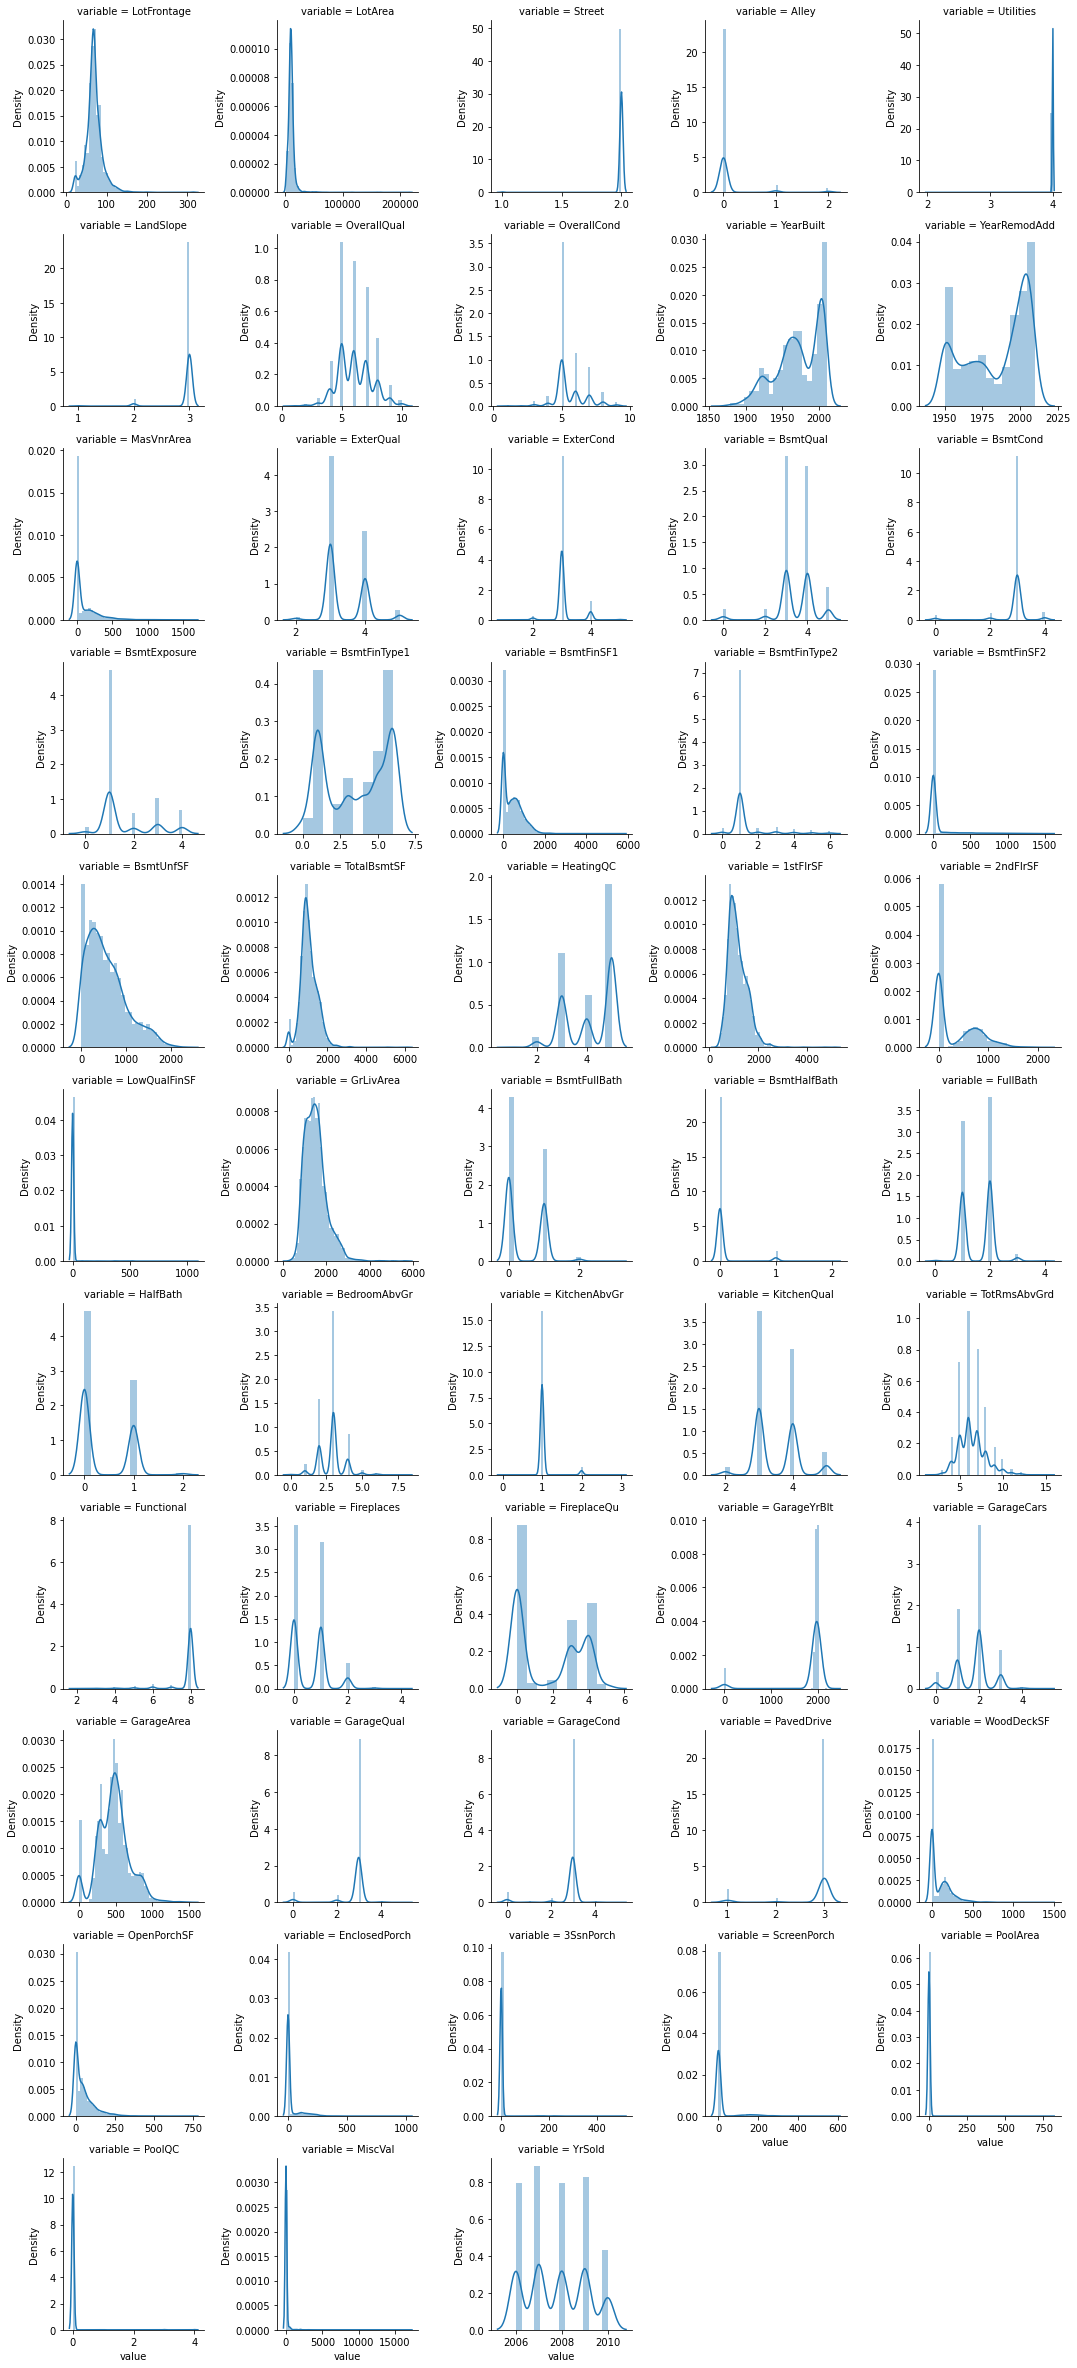

In [74]:
# visualize the distribution of each numerical feature
temp = pd.melt(df, value_vars=num_columns)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

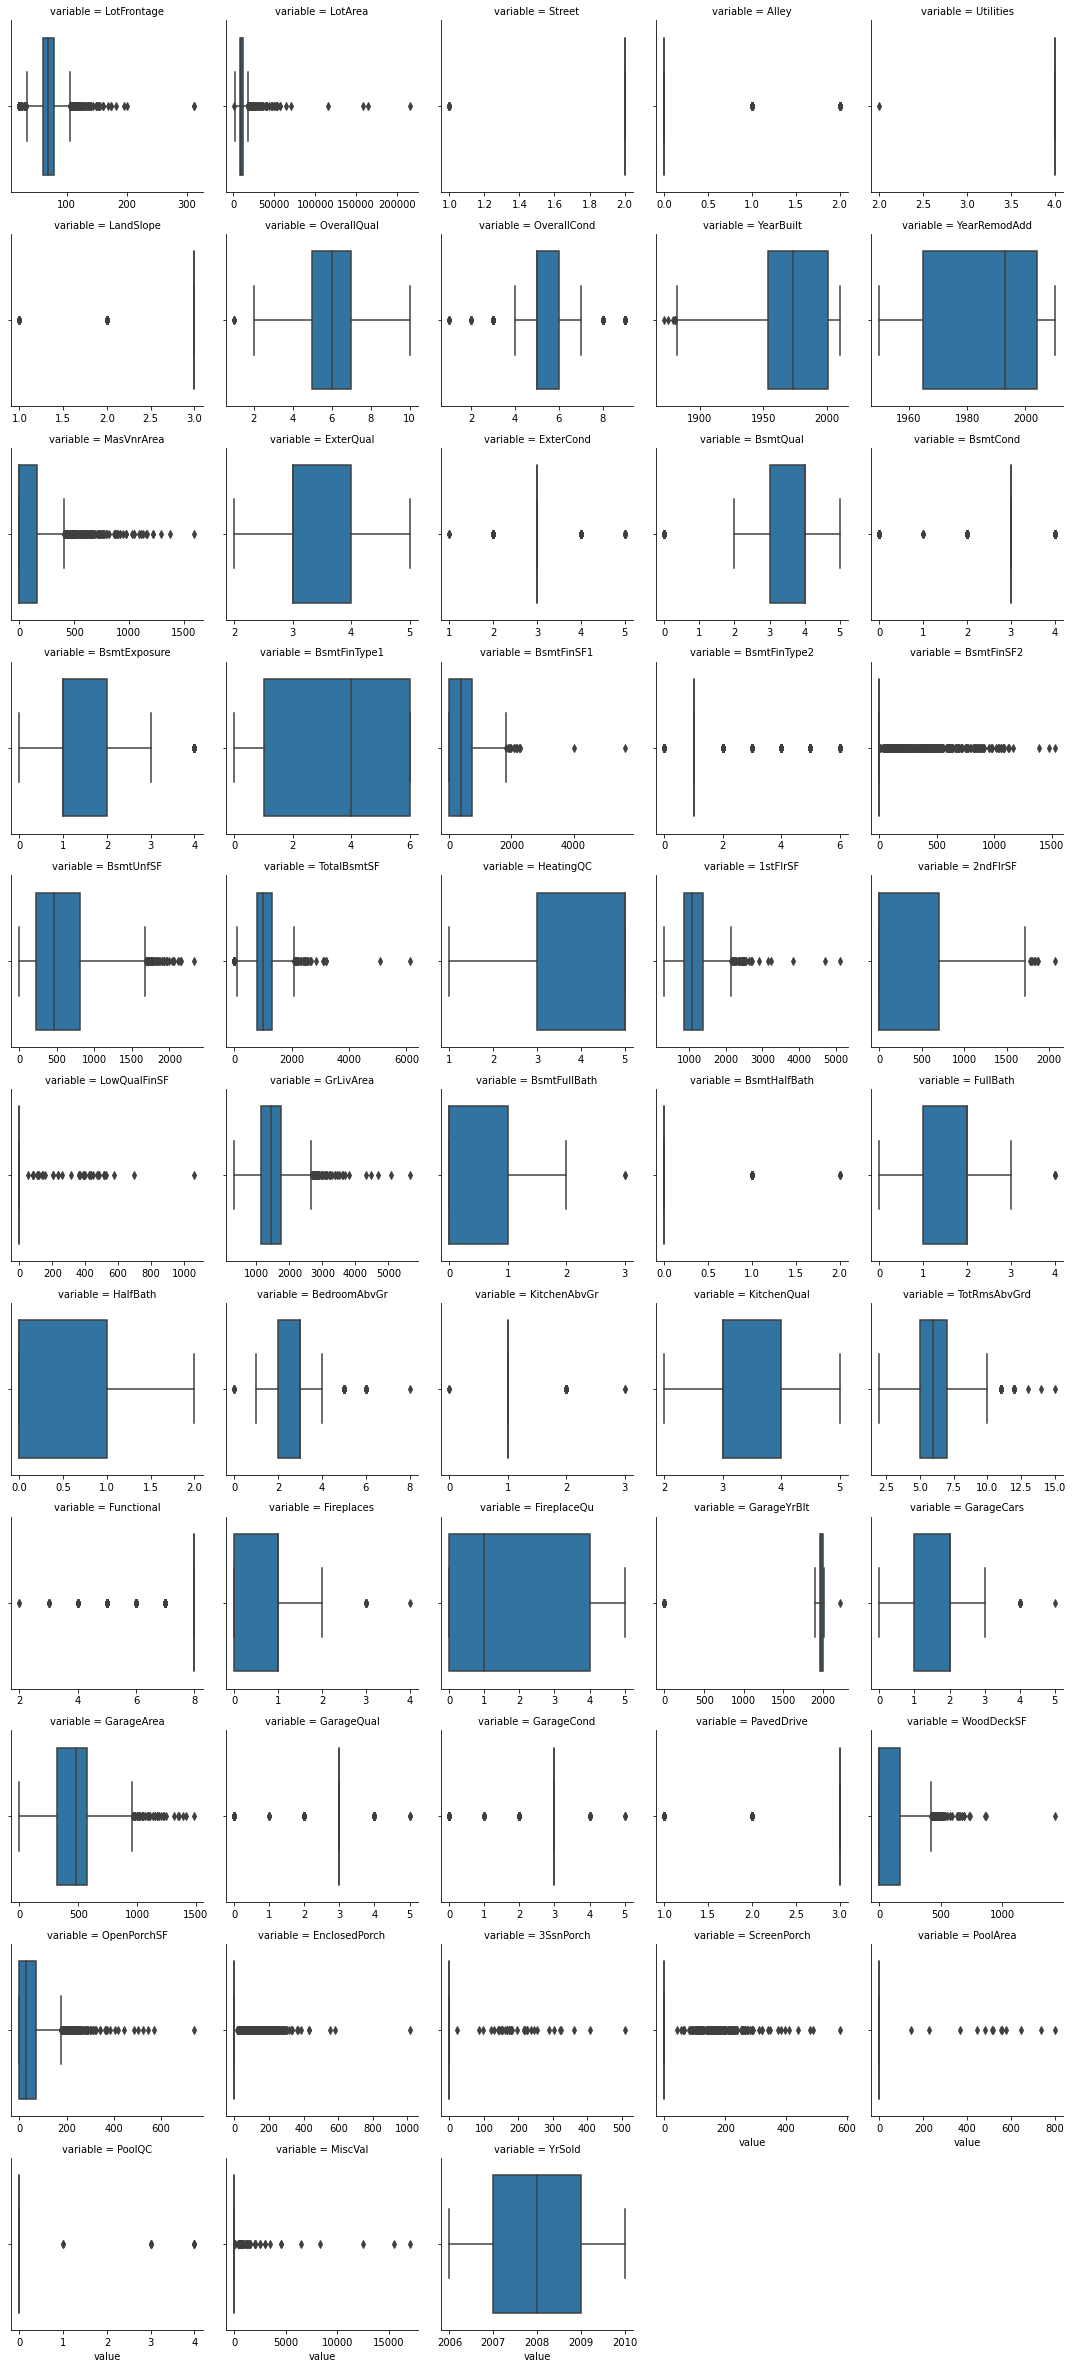

In [75]:
# box-plot of each numerical feature
temp = pd.melt(df, value_vars=num_columns)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.boxplot, "value")
plt.show()

In [76]:
df = df.reset_index()
df = df.drop('index',axis = 1)

In [77]:
drop_id = df[df['LotArea'] > 100000].index

In [78]:
# we can to remove lines only from training
drop_id = drop_id[drop_id < 1459]

In [79]:
# change some position in dataframe.
df['MasVnrArea'][df[df['MasVnrArea'] > 1500].index] = df['MasVnrArea'].mean()
df['Utilities'][df[df['Utilities']==2].index] = df['Utilities'].mean()

In [80]:
df = df.drop(drop_id)

In [81]:
df = df.reset_index()

In [82]:
y_train = y_train.drop(drop_id)

# 5. Encoding categorical


Create dummy variables and delete the last column generated from each categorical feature

In [83]:
# create of list of dummy variables for drop
dummy_drop = []
for i in cat_columns:
    dummy_drop += [ i+'_'+str(df[i].unique()[-1]) ]

df = pd.get_dummies(df,columns=cat_columns) 
# drop the last column generated from each categorical feature
df = df.drop(dummy_drop,axis=1)

In [84]:
X_train  = df[:-1459].drop(['index'], axis=1)
X_test  = df[-1459:].drop(['index'], axis=1)

scaler = StandardScaler()
X_train[num_columns]= scaler.fit_transform(X_train[num_columns])
X_test[num_columns]= scaler.transform(X_test[num_columns])

X_train.shape, X_test.shape 

((1455, 222), (1459, 222))

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. Therefore, we convert the data to a logarithm

In [85]:
y_train_log = np.log(y_train)

# 6. Chose the most important feature

In [86]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
imp_feature = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp_feature = imp_feature.sort_values(['Importance'], ascending = False)

print(imp_feature)

                     Importance
OverallQual            0.303174
CentralAir_Y           0.128662
KitchenAbvGr           0.086335
KitchenQual            0.062555
GarageCars             0.052719
...                         ...
MSSubClass_class4      0.000000
BldgType_Duplex        0.000000
Exterior2nd_CmentBd    0.000000
MSSubClass_class7      0.000000
Exterior2nd_CBlock     0.000000

[222 rows x 1 columns]


In [87]:
ans = {}
# choose the most important feature
for i in range(1, 222):
    imp_col = imp_feature.iloc[:i].index
    # these parameters are taken from previous experiments
    ridge = KernelRidge(alpha = 0.5263157894736842, coef0 = 3.5, degree = 2, kernel ='polynomial')
    ridge = ridge.fit(X_train[imp_col], y_train_log)
    ans[i] = np.sqrt(mean_squared_error(y_train_log,ridge.predict(X_train[imp_col])))

In [88]:
minimum = ans[1]
ind_min = 1
for ind in range(1,len(ans.values())):
    if ans[ind] < minimum:
        minimum = ans[ind]
        ind_min = ind

In [89]:
imp_col = imp_feature.iloc[:ind_min+1].index

# 7. Model

## 7.1 Kernel Ridge

In [90]:
# metric
def neg_rmse(y_true, y_pred):
    return -1.0*np.sqrt(mean_squared_error(y_true,y_pred))

neg_rmse = make_scorer(neg_rmse)

In [91]:
ridge = KernelRidge()

parameters = {'alpha': np.linspace(0, 1,20), 'kernel': ['polynomial','sigmoid','chi2','laplacian'], 
              'degree': [2], 'coef0':np.linspace(0, 3.5,21)}

grid_cv = GridSearchCV(estimator = ridge,
                                   param_grid = parameters,
                                   cv = 3,
                                   scoring = neg_rmse,
                                   n_jobs = -1)

grid_cv = grid_cv.fit(X_train[imp_col], y_train_log)

print("Parameters of the best_estimator:")
print(grid_cv.best_params_)
print("Mean cross-validated RMSE of the best_estimator: {}".format(-grid_cv.best_score_))
model = grid_cv.best_estimator_
print("RMSE of the whole training set: {}".format(np.sqrt(mean_squared_error(y_train_log,model.predict(X_train[imp_col])))))

Parameters of the best_estimator:
{'alpha': 0.6842105263157894, 'coef0': 3.5, 'degree': 2, 'kernel': 'polynomial'}
Mean cross-validated RMSE of the best_estimator: 0.11967577983870975
RMSE of the whole training set: 0.0867704617908937


In [92]:
# inverse conversion to logarithm
y_pred = np.exp(model.predict(X_test[imp_col]))

In [93]:
def save_ans(ans, pasanger_id, name_alg):
    submission = pd.DataFrame({'Id':pasanger_id,'SalePrice':ans})
    print(submission.shape) 
    filename = r'data\answers\{}.csv'.format(name_alg)
    submission.to_csv(filename,index=False)
    print('Saved file: ' + filename)

In [94]:
save_ans(y_pred, test_id,'kernel_ridge')

(1459, 2)
Saved file: data\answers\kernel_ridge.csv
